# Tutorial 1: Data Preparation

Welcome to this tutorial on using the `mTopic` package to prepare data for multimodal topic modeling of single-cell data. The `mTopic` package supports spatial and non-spatial multimodal topic modeling, enabling the discovery of complex patterns across multiple modalities in single-cell experiments.

Data preprocessing is a crucial first step in any single-cell analysis workflow. It ensures the data is clean, well-structured, and suitable for downstream modeling. This includes filtering out uninformative features, normalizing raw counts, and aligning modalities for comparability. These steps are essential to produce biologically meaningful and statistically robust topic models.

This tutorial will demonstrate how to preprocess a multimodal dataset in preparation for topic modeling using `mTopic`.

We will use a publicly available dataset from [10x Genomics](https://www.10xgenomics.com/datasets/gene-protein-expression-library-of-human-tonsil-cytassist-ffpe-2-standard), which includes gene expression and protein measurements from human tonsil tissue processed with the CytAssist FFPE protocol. A preprocessed `.h5mu` file version of this dataset is available at [https://doi.org/10.5281/zenodo.15387482](https://doi.org/10.5281/zenodo.15387482)

We will begin by importing the required libraries and downloading the dataset from Zenodo.

In [1]:
import mtopic
import scanpy as sc

! wget -O Human_Tonsil_RNA_Protein_raw.h5mu \
  "https://zenodo.org/records/15387482/files/Human_Tonsil_RNA_Protein_raw.h5mu?download=1"

--2025-05-12 20:36:43--  https://zenodo.org/records/15387482/files/Human_Tonsil_RNA_Protein_raw.h5mu?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74208989 (71M) [application/octet-stream]
Saving to: ‘Human_Tonsil_RNA_Protein_raw.h5mu’

Human_Tonsil_RNA_Pr 100%[===================>]  70.77M  54.4MB/s    in 1.3s    

2025-05-12 20:36:45 (54.4 MB/s) - ‘Human_Tonsil_RNA_Protein_raw.h5mu’ saved [74208989/74208989]



The `mTopic` package operates on `MuData` objects, which organize multimodal single-cell data by combining multiple `AnnData` layers—each representing a modality such as RNA, ATAC, or protein—into a single structure. These are stored in `.h5mu` files, an HDF5-based format optimized for efficient access and integration.

In this tutorial, we load a `MuData` object named `ton`, which contains raw RNA and protein data from human tonsil tissue.

In [2]:
ton = mtopic.read.h5mu('Human_Tonsil_RNA_Protein_raw.h5mu')

ton

MuData object with n_obs × n_vars = 4194 × 19006
  obs:	'in_tissue'
  var:	'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_counts'
  obsm:	'coords'
  2 modalities
    rna:	4194 x 18977
      obs:	'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_counts'
    prot:	4194 x 29
      obs:	'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_counts'

Before running topic modeling, the data must be preprocessed to ensure it is clean, informative, and suitable for analysis. The filtering pipeline includes the following steps:

- **Permutation of counts** (`mtopic.pp.permute`):  
  Randomizes cell counts within each feature to estimate technical noise and identify overrepresented features.

- **Transformation of count matrices**:  
  **TF-IDF** (`mtopic.pp.tfidf`) is applied to ATAC, histone, and RNA data to highlight informative features (here, only to RNA, as other modalities are unavailable).  
  **CLR normalization** (`mtopic.pp.clr`) is used for protein data to correct compositional bias.


- **Scaling counts** (`mtopic.pp.scale_counts`):  
  Scales total counts across modalities to ensure equal contribution during modeling.

These steps improve data quality and reduce technical artifacts, enhancing the interpretability of the resulting topics.

In [3]:
mtopic.pp.permute(ton)
mtopic.pp.tfidf(ton, mod='rna')
mtopic.pp.clr(ton, mod='prot')
mtopic.pp.scale_counts(ton)

The data is now ready for an initial round of topic modeling to help identify technical noise and overrepresented features. We recommend training a simple `scmtm.tl.MTM` model for this step.

If working with a large dataset, consider selecting a representative subset of cells to reduce runtime. For smaller datasets, such as the one used here, which contains 4,194 spatial spots, the filtering model can be trained on the full dataset.

In [4]:
MTM = mtopic.tl.MTM(ton, n_topics=10, n_jobs=100)
MTM.VI(n_iter=30)

100%|███████████████████████████████████████████| 30/30 [02:26<00:00,  4.89s/it]


After training the filtering-oriented model, the next step is to identify overrepresented features with disproportionately high cumulative activity across all topics. These features often reflect technical noise rather than a meaningful biological signal.

We apply a knee detection algorithm to filter them, which identifies a sharp drop in cumulative feature activity and defines a cutoff point for filtering. The sensitivity of this detection is controlled by the `knee_sensitivity` parameter (`S`), which determines how pronounced the drop must be to qualify as a knee. Lower values of `S` result in more aggressive filtering, while higher values yield more conservative thresholds.

For example, below is a knee plot for the RNA modality, showing the distribution of feature activity and the detected cutoff.

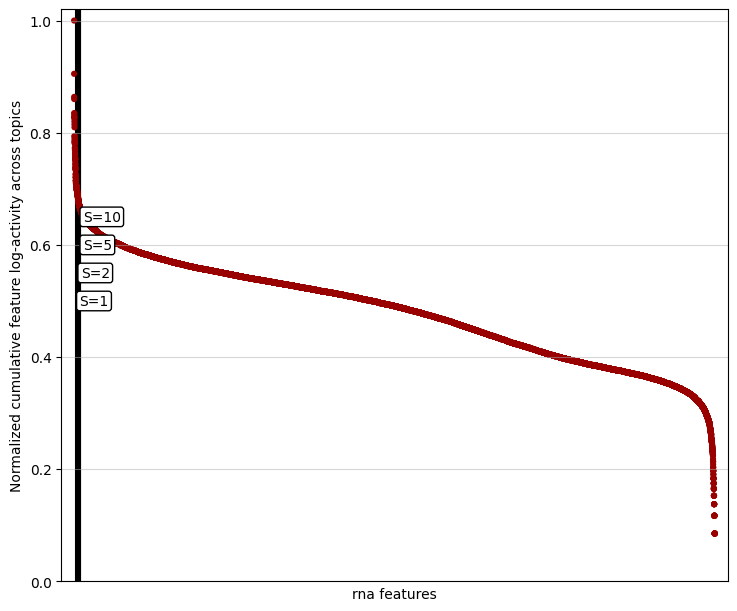

In [5]:
mtopic.pl.filter_var_knee(MTM, mod='rna')

In datasets with many features, the knee point may be challenging to detect due to the dense distribution of activity values. To improve visibility, you can limit the plot to the top-scoring features by adjusting the `show_frac` parameter.

The `show_frac` parameter controls the fraction of features to display, focusing on those with the highest cumulative activity across topics. Reducing this fraction can make the knee point more apparent, simplifying the selection of features to filter for a cleaner and more interpretable analysis.

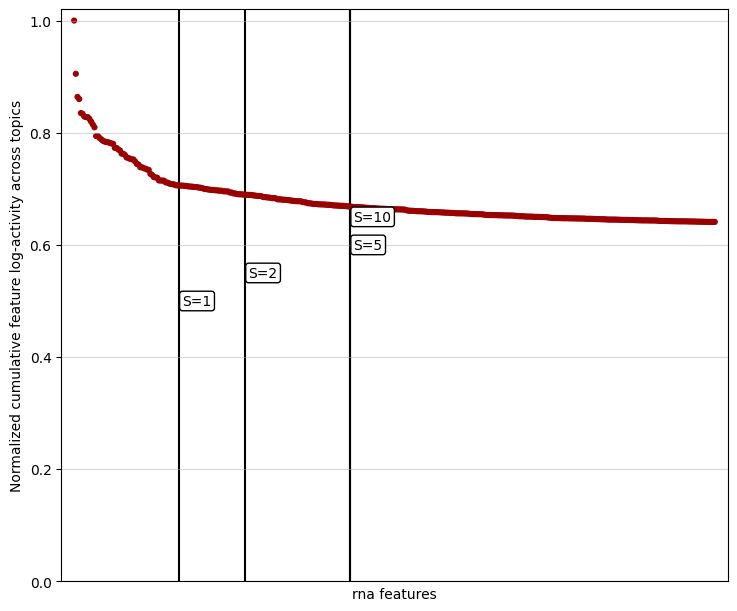

In [6]:
mtopic.pl.filter_var_knee(MTM, mod='rna', show_frac=0.02)

Once the appropriate `knee_sensitivity` values have been selected for each modality, you can filter out the overrepresented features using the `mtopic.pp.filter_var_knee` function. This step refines the dataset by removing features that contribute primarily to noise. The filtered `MuData` object can then be saved for downstream modeling.

In [7]:
ton_filtered = mtopic.pp.filter_var_knee(path='Human_Tonsil_RNA_Protein_raw.h5mu', model=MTM, knee_sensitivity=10)

Alternatively, if you have a predefined list of features to retain, you can use the `scmtm.pp.filter_var_list` function. This method allows precise control over which features are preserved in the dataset.

If RNA is one of the data modalities, we recommend further refining the feature set by selecting highly variable genes (HVGs). HVGs exhibit the most significant variability across cells and often carry the most biologically relevant signal.

In [8]:
rna = ton_filtered['rna'].copy()
sc.pp.highly_variable_genes(rna, flavor='seurat_v3', n_top_genes=5000)
selected_genes = rna[:, rna.var.highly_variable].var.index.tolist()

selected_proteins = ton_filtered['prot'].var.index.tolist()

ton_filtered = mtopic.pp.filter_var_list(path='Human_Tonsil_RNA_Protein_raw.h5mu', var = selected_genes + selected_proteins)

Make sure to save the processed `MuData` object after filtering to be used for downstream topic model training.

In [9]:
#ton_filtered.write('Human_Tonsil_RNA_Protein_filtered.h5mu')